# Installing Pyspark

In [3]:
# install PySpark 
#http://spark.apache.org/docs/latest/api/python/index.html

!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 14.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=e740527130fda7c2df9529f17e43589c7bffe6f80a24565134f0e2cb3cf39c0d
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


# Starting the  pyspark session and configuration

In [4]:
# starting thw spark session and configuration
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/22 06:34:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Importing all Libraries required


In [5]:
#importing all the necessary libraries for anaylyses and visualisations
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
import csv
import matplotlib.pyplot as plt
import glob
import os
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon
import plotly.express as px
import geoplot as gplt
import geoplot.crs as gcrs
import warnings
from pyspark.sql.functions import desc

warnings.filterwarnings("ignore")

# Loading the data

In [6]:
# Loading the data
CrimeinWales = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/wales-crime-data")

# Total Counts of the Datasets

In [7]:
# Get the count of the dataset
CrimeinWales.select(count("*")).show()

+--------+
|count(1)|
+--------+
|  153704|
+--------+



# Getting details of elements and attributes of the data

In [8]:
# Getting details of elements and attributes of the data
CrimeinWales.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



# Renaming the Column headers


In [9]:
# tidy up the column names

CrimeinWales = CrimeinWales.withColumnRenamed('Crime ID', 'Crime_ID')
CrimeinWales = CrimeinWales.withColumnRenamed('Reported by', 'Reported_by')
CrimeinWales = CrimeinWales.withColumnRenamed('Falls within', 'Falls_within')
CrimeinWales = CrimeinWales.withColumnRenamed('LSOA code', 'LSOA_code')
CrimeinWales= CrimeinWales.withColumnRenamed('LSOA name', 'LSOA_name')
CrimeinWales = CrimeinWales.withColumnRenamed('Crime type', 'Crime_type')
CrimeinWales= CrimeinWales.withColumnRenamed('Last outcome category', 'Last_outcome_category')

# Getting a list of the rows

In [10]:
# Getting a list of the rows
CrimeinWales.take

<bound method DataFrame.take of DataFrame[Crime_ID: string, Month: string, Reported_by: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA_name: string, Crime_type: string, Last_outcome_category: string, Context: string]>

# Retrieving details of first 5 rows

In [11]:
CrimeinWales.show(5)

+--------------------+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|       Reported_by|      Falls_within|Longitude| Latitude|            Location|LSOA_code|         LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+---------------------+-------+
|848c31884cbc3c3a0...|2021-03|South Wales Police|South Wales Police|-1.465837| 53.55122|On or near Beevor...|E01007337|     Barnsley 015D|Violence and sexu...| Unable to prosecu...|   null|
|764b46390635093ef...|2021-03|South Wales Police|South Wales Police|-3.263216|51.785239|On or near Lakesi...|W01001474|Blaenau Gwent 003C|Violence and sexu...| Status update una...|   null|
|5d95631620fc70733...|2021-03|South Wales Police|S

# Retrieving details of the important columns for the analyses

In [12]:
# Select important columns required for the analyses from the dataset
CrimeinWales_Data = CrimeinWales.select(['Month','Reported_by','Falls_within','Longitude','Latitude','Location','LSOA_code','LSOA_name',
 'Crime_type'])
CrimeinWales_Data.show(5)

+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|  Month|       Reported_by|      Falls_within|Longitude| Latitude|            Location|LSOA_code|         LSOA_name|          Crime_type|
+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|2021-03|South Wales Police|South Wales Police|-1.465837| 53.55122|On or near Beevor...|E01007337|     Barnsley 015D|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.263216|51.785239|On or near Lakesi...|W01001474|Blaenau Gwent 003C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.209428| 51.78246|On or near Parkin...|W01001456|Blaenau Gwent 004C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.158945| 51.75791|On or near Aberti...|W01001445|Blaenau Gwent 005C|Violence and sexu...|
|2021-03|South Wales Police

# creating a temporary table

In [13]:
#creating a temporary table
CrimeinWales_Data.registerTempTable("CrimeinWales_Table")

In [14]:
sqlContext.sql("select * from CrimeinWales_Table").show(5)

+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|  Month|       Reported_by|      Falls_within|Longitude| Latitude|            Location|LSOA_code|         LSOA_name|          Crime_type|
+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|2021-03|South Wales Police|South Wales Police|-1.465837| 53.55122|On or near Beevor...|E01007337|     Barnsley 015D|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.263216|51.785239|On or near Lakesi...|W01001474|Blaenau Gwent 003C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.209428| 51.78246|On or near Parkin...|W01001456|Blaenau Gwent 004C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.158945| 51.75791|On or near Aberti...|W01001445|Blaenau Gwent 005C|Violence and sexu...|
|2021-03|South Wales Police

# Data Pre processing


In [15]:
#making a copy of the data
CrimeinWales_data=CrimeinWales_Data
CrimeinWales_data.show(2)

+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|  Month|       Reported_by|      Falls_within|Longitude| Latitude|            Location|LSOA_code|         LSOA_name|          Crime_type|
+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|2021-03|South Wales Police|South Wales Police|-1.465837| 53.55122|On or near Beevor...|E01007337|     Barnsley 015D|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.263216|51.785239|On or near Lakesi...|W01001474|Blaenau Gwent 003C|Violence and sexu...|
+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
only showing top 2 rows



In [16]:
#viewing the data in pandas
CrimeinWales_data.describe().toPandas()

,summary,Month,Reported_by,Falls_within,Longitude,Latitude,Location,LSOA_code,LSOA_name,Crime_type
0,count,153704,153704,153704,151113,151113,153704,151113,151113,153704
1,mean,None,None,None,-3.4846353734887523,52.12127451563251,None,None,None,None
2,stddev,None,None,None,0.3792971184251614,0.7726254839413114,None,None,None,None
3,min,2021-01,North Wales Police,North Wales Police,-4.936811,50.670962,No Location,E01004814,Allerdale 010A,Anti-social behaviour
4,max,2023-03,South Wales Police,South Wales Police,-0.102538,54.826727,On or near Zouch Street,W01001958,Wrexham 020I,Violence and sexual offences


# Dropping missing values.

In [17]:
# Drop rows with null values in any column
CrimeinWales_data2 = CrimeinWales_data.dropna()

# Show the resulting DataFrame
CrimeinWales_data2.show()

+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|  Month|       Reported_by|      Falls_within|Longitude| Latitude|            Location|LSOA_code|         LSOA_name|          Crime_type|
+-------+------------------+------------------+---------+---------+--------------------+---------+------------------+--------------------+
|2021-03|South Wales Police|South Wales Police|-1.465837| 53.55122|On or near Beevor...|E01007337|     Barnsley 015D|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.263216|51.785239|On or near Lakesi...|W01001474|Blaenau Gwent 003C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.209428| 51.78246|On or near Parkin...|W01001456|Blaenau Gwent 004C|Violence and sexu...|
|2021-03|South Wales Police|South Wales Police|-3.158945| 51.75791|On or near Aberti...|W01001445|Blaenau Gwent 005C|Violence and sexu...|
|2021-03|South Wales Police

# counting the data after dropping the missing values

In [18]:
# Get the count of the dataset after dropping missing values.
CrimeinWales_data2.select(count("*")).show()

+--------+
|count(1)|
+--------+
|  151113|
+--------+



In [19]:

CrimeinWales_data2.registerTempTable("CrimeinWales2_Table")

# Count Of Crime by Month

In [20]:
#get the counts for each month ordered in descending order
CrimeinWales_data2.groupby("Month").count().orderBy(desc("count")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2021-03|19670|
|2022-03|17257|
|2021-01|17233|
|2023-03|17141|
|2021-02|16420|
|2022-01|16381|
|2023-02|16066|
|2023-01|15563|
|2022-02|15382|
+-------+-----+



 # Creating a new data frame with Month and Counts per Month

In [21]:
# Create new data frame with Month and Counts per Month
WalesCrime2 = CrimeinWales_data2.select(CrimeinWales_data.Month)\
.groupby(CrimeinWales_data2.Month).count()
WalesCrime2.show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2021-03|19670|
|2021-02|16420|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2021-01|17233|
|2022-01|16381|
|2022-02|15382|
+-------+-----+



# Creating a Bar chart for Visualisation 

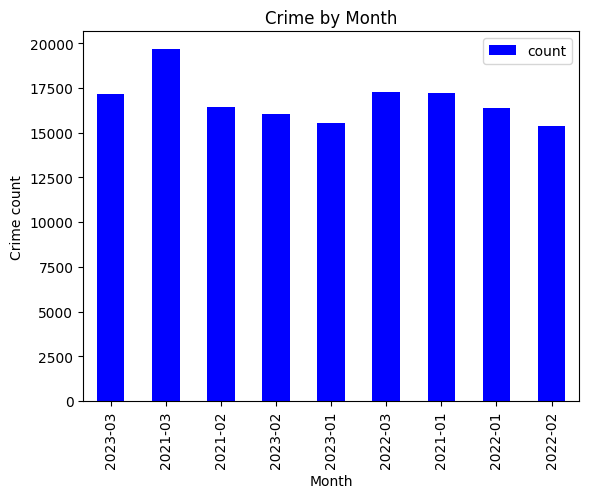

In [22]:
import matplotlib.pyplot as plt

# coverting to Pandas from PySpark DataFrame
Crime_Month = WalesCrime2.toPandas()

# Creating a barchart of crime count by type
axis = Crime_Month.plot(kind='bar', x='Month', y='count', color='blue')

# Setting the chart title and axis labels
axis.set_title('Crime by Month')
axis.set_xlabel('Month')
axis.set_ylabel('Crime count')

# Show the chart
plt.show()

In [23]:
WalesCrime2.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



In [24]:
WalesCrime2.orderBy(desc("Month")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2022-02|15382|
|2022-01|16381|
|2021-03|19670|
|2021-02|16420|
|2021-01|17233|
+-------+-----+



In [25]:
WalesCrime2.registerTempTable("CrimeinWales_Tbl")

In [26]:
sqlContext.sql("select * from CrimeinWales_Tbl").show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2021-03|19670|
|2021-02|16420|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2021-01|17233|
|2022-01|16381|
|2022-02|15382|
+-------+-----+



In [27]:
# Create new dataframe with month, total, and averages
WalesMonthlyCrime= sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(count) as Total, avg(count) as \
Average from CrimeinWales_Tbl group by substring(Month, 6, 2)")

In [28]:
# Register the table for Monthly crime
# DataFrame as a temp table and show the contents
WalesMonthlyCrime.registerTempTable("WalesMonthlyCrime")
sqlContext.sql("select * from CrimeinWales_Tbl").show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2021-03|19670|
|2021-02|16420|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2021-01|17233|
|2022-01|16381|
|2022-02|15382|
+-------+-----+



In [29]:
WalesMonthlyCrime= WalesMonthlyCrime.orderBy('Month')

# Crime Aggregation

In [30]:
WalesMonthlyCrime.show()

+-----+-----+------------------+
|Month|Total|           Average|
+-----+-----+------------------+
|   01|49177|16392.333333333332|
|   02|47868|           15956.0|
|   03|54068|18022.666666666668|
+-----+-----+------------------+



In [31]:
# Register the monthly crime
# DataFrame as a temp table and show the contents
WalesMonthlyCrime.registerTempTable("WalesMonthlyCrime")
sqlContext.sql("select * from CrimeinWales_Tbl").show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2021-03|19670|
|2021-02|16420|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2021-01|17233|
|2022-01|16381|
|2022-02|15382|
+-------+-----+



In [32]:
# Prepare variables for visualisations

monthArray = sqlContext.sql("select Month from WalesMonthlyCrime")\
.rdd.map(lambda f:f[0]).collect()
monthTotalArray = sqlContext.sql("select Total from WalesMonthlyCrime")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from WalesMonthlyCrime")\
.rdd.map(lambda f:f[0]).collect()

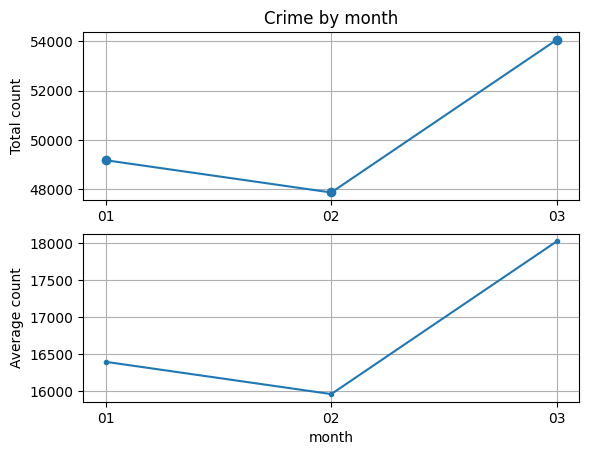

In [33]:
import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime by month')
plt.ylabel('Total count')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('month')
plt.ylabel('Average count')
plt.grid(True)
plt.savefig("Crime by month.png")
plt.show()

# count of crime by year

In [34]:
#retrieve yearly amount of crimes sorted descendantly
CrimeinWales_data2.select(substring(CrimeinWales.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+-----+
|Year|count|
+----+-----+
|2021|53323|
|2022|49020|
|2023|48770|
+----+-----+



In [35]:
# Create dataframe to retrieve information by year (total and average)
WalesyearlyCrime = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
CrimeinWales_Tbl group by substring(Month, 0, 4)")
WalesyearlyCrime.show()

+----+-----+------------------+
|Year|Total|           Average|
+----+-----+------------------+
|2022|49020|           16340.0|
|2023|48770|16256.666666666666|
|2021|53323|17774.333333333332|
+----+-----+------------------+



In [36]:
# Register the yearly data in a temp table and show the contents
WalesyearlyCrime.registerTempTable("WalesyearlyCrime")
sqlContext.sql("select * from WalesyearlyCrime").show()

+----+-----+------------------+
|Year|Total|           Average|
+----+-----+------------------+
|2022|49020|           16340.0|
|2023|48770|16256.666666666666|
|2021|53323|17774.333333333332|
+----+-----+------------------+



In [37]:
# Prepare variables for visualisations

totalArray = sqlContext.sql("select Total from WalesyearlyCrime")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from WalesyearlyCrime")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from WalesyearlyCrime")\
.rdd.map(lambda f:f[0]).collect()

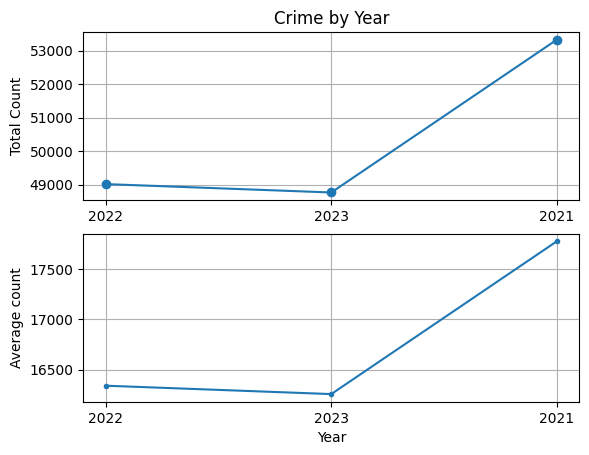

In [38]:
# Plot visualisations
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime by Year')
plt.ylabel('Total Count')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average count')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [39]:
sqlContext.sql("select * from CrimeinWales_Tbl").show()

+-------+-----+
|  Month|count|
+-------+-----+
|2023-03|17141|
|2021-03|19670|
|2021-02|16420|
|2023-02|16066|
|2023-01|15563|
|2022-03|17257|
|2021-01|17233|
|2022-01|16381|
|2022-02|15382|
+-------+-----+



# retrieving details of crime type

In [40]:
walescrimegcategory = spark.sql("select distinct Crime_type from CrimeinWales_Table")
walescrimegcategory.show()
walescrimegcategory.count()

+--------------------+
|          Crime_type|
+--------------------+
|       Bicycle theft|
|        Public order|
|               Drugs|
|         Other crime|
|             Robbery|
|Criminal damage a...|
|Theft from the pe...|
|         Shoplifting|
|            Burglary|
|         Other theft|
|Possession of wea...|
|Violence and sexu...|
|       Vehicle crime|
|Anti-social behav...|
+--------------------+



14

In [41]:
walescrimegcategory = spark.sql("select distinct Crime_type,Falls_within from CrimeinWales_Table")
walescrimegcategory.show(30)
walescrimegcategory.count()

+--------------------+------------------+
|          Crime_type|      Falls_within|
+--------------------+------------------+
|Violence and sexu...|South Wales Police|
|         Shoplifting|South Wales Police|
|        Public order|South Wales Police|
|            Burglary|South Wales Police|
|Theft from the pe...|South Wales Police|
|         Other crime|South Wales Police|
|Criminal damage a...|South Wales Police|
|             Robbery|South Wales Police|
|       Vehicle crime|South Wales Police|
|               Drugs|South Wales Police|
|Possession of wea...|South Wales Police|
|       Bicycle theft|South Wales Police|
|         Other theft|South Wales Police|
|Anti-social behav...|South Wales Police|
|         Other crime|North Wales Police|
|       Vehicle crime|North Wales Police|
|               Drugs|North Wales Police|
|Violence and sexu...|North Wales Police|
|Anti-social behav...|North Wales Police|
|         Shoplifting|North Wales Police|
|         Other theft|North Wales 

28

In [42]:
CrimeinWales2= CrimeinWales_data2.select("Crime_type", "Month")
CrimeinWales2.show()
print ("Crime Category: ")
CrimeinWales2.count()

+--------------------+-------+
|          Crime_type|  Month|
+--------------------+-------+
|Violence and sexu...|2021-03|
|Violence and sexu...|2021-03|
|Violence and sexu...|2021-03|
|Violence and sexu...|2021-03|
|Violence and sexu...|2021-03|
|Anti-social behav...|2021-03|
|Anti-social behav...|2021-03|
|Anti-social behav...|2021-03|
|Anti-social behav...|2021-03|
|Anti-social behav...|2021-03|
|Criminal damage a...|2021-03|
|               Drugs|2021-03|
|        Public order|2021-03|
|Violence and sexu...|2021-03|
|Violence and sexu...|2021-03|
|            Burglary|2021-03|
|            Burglary|2021-03|
|Criminal damage a...|2021-03|
|        Public order|2021-03|
|Violence and sexu...|2021-03|
+--------------------+-------+
only showing top 20 rows

Crime Category: 


151113

# retrieving details of crime type count by Month

# Categorising the crime type

In [43]:
CrimeinWales2_category = (CrimeinWales_data2.select('*') .groupBy('Crime_type') 
                          .agg(count("Crime_type").alias('Total_crime'))
                          .orderBy('Total_crime',ascending=False))

CrimeinWales2_category.show()


CrimeinWales2_category.agg({"Total_crime": "sum"}).show()
CrimeinWales2_category.count()

+--------------------+-----------+
|          Crime_type|Total_crime|
+--------------------+-----------+
|Violence and sexu...|      51754|
|Anti-social behav...|      36888|
|        Public order|      14201|
|Criminal damage a...|      12854|
|         Shoplifting|       8428|
|         Other theft|       7937|
|       Vehicle crime|       5435|
|            Burglary|       4240|
|               Drugs|       3923|
|         Other crime|       2477|
|       Bicycle theft|       1134|
|Possession of wea...|        766|
|Theft from the pe...|        603|
|             Robbery|        473|
+--------------------+-----------+

+----------------+
|sum(Total_crime)|
+----------------+
|          151113|
+----------------+



14

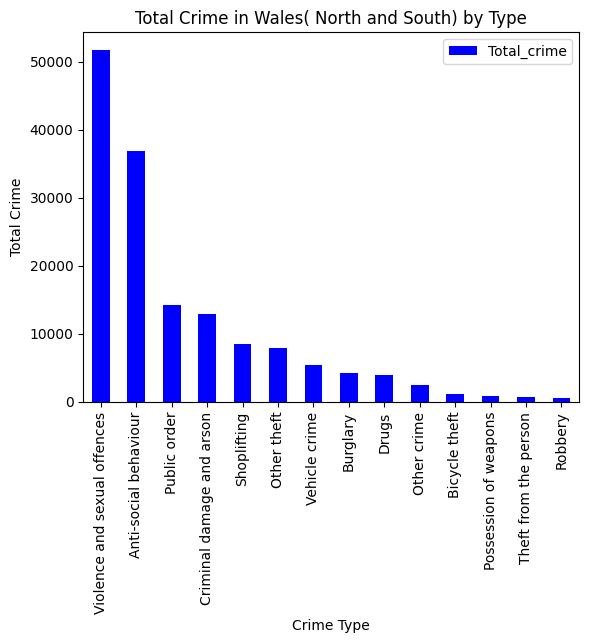

In [44]:
import matplotlib.pyplot as plt

# covert to Pandas from your PySpark DataFrame
crime_type = CrimeinWales2_category.toPandas()

# Create a bar chart of total crime by type
axis = crime_type.plot(kind='bar', x='Crime_type', y='Total_crime', color='blue')

# Set the chart title and axis labels
axis.set_title('Total Crime in Wales( North and South) by Type')
axis.set_xlabel('Crime Type')
axis.set_ylabel('Total Crime')

# Show the chart
plt.show()

# Viewing the crime category in a pandas frame


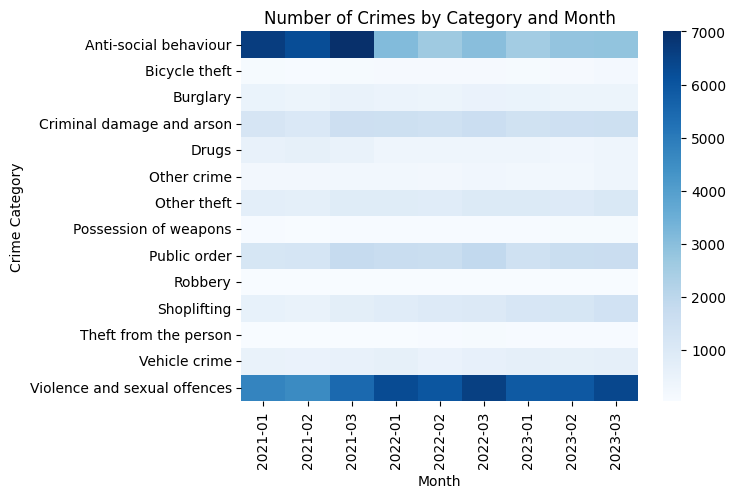

In [67]:
import seaborn as sns
import pandas as pd

# group by Crime_type and Month, and count the total number of crimes for each group
walescrime_counts = CrimeinWales_data2.groupBy(['Crime_type', 'Month']) \
    .agg(count('*').alias('Total Crimes')) \
    .orderBy(['Crime_type', 'Month'])

# convert the Spark dataframe to a Pandas dataframe
wales_pandas = walescrime_counts.toPandas()

# create a pivot table with Crime_type as rows and Month as columns, and Total Crimes as values
wales_pivot = wales_pandas.pivot_table(index='Crime_type', columns='Month', values='Total Crimes', fill_value=0)

# create a heatmap with the pivot table, using the Reds colormap
sns.heatmap(wales_pivot, cmap='Blues')
plt.xlabel('Month')
plt.ylabel('Crime Category')
plt.title('Number of Crimes by Category and Month')
plt.show()

In [46]:
CrimeinWales2_category = (CrimeinWales2.select('*')
        .groupBy('Crime_type', 'Month')
        .agg(count("Crime_type").alias('Total_Crime'))
        .orderBy('Month')
               )

CrimeinWales2_category.toPandas()

,Crime_type,Month,Total_Crime
0,Public order,2021-01,1195
1,Other theft,2021-01,723
2,Robbery,2021-01,63
3,Other crime,2021-01,245
4,Anti-social behaviour,2021-01,6639
...,...,...,...
121,Criminal damage and arson,2023-03,1518
122,Possession of weapons,2023-03,108
123,Anti-social behaviour,2023-03,2865
124,Shoplifting,2023-03,1377


In [47]:
CrimeinWales2_category.toPandas()

,Crime_type,Month,Total_Crime
0,Public order,2021-01,1195
1,Other theft,2021-01,723
2,Robbery,2021-01,63
3,Other crime,2021-01,245
4,Anti-social behaviour,2021-01,6639
...,...,...,...
121,Criminal damage and arson,2023-03,1518
122,Possession of weapons,2023-03,108
123,Anti-social behaviour,2023-03,2865
124,Shoplifting,2023-03,1377


In [48]:
CrimeinWales2_category = (CrimeinWales2.select('*')
        .groupBy('Crime_type', 'Month')
        .agg(count("Crime_type").alias('Total_Crime'))
        .orderBy('Month')
               )

CrimeinWales2_category.show(1000)
CrimeinWales2_category.count()

+--------------------+-------+-----------+
|          Crime_type|  Month|Total_Crime|
+--------------------+-------+-----------+
|         Shoplifting|2021-01|        590|
|         Other theft|2021-01|        723|
|         Other crime|2021-01|        245|
|Possession of wea...|2021-01|         87|
|Violence and sexu...|2021-01|       4746|
|Anti-social behav...|2021-01|       6639|
|            Burglary|2021-01|        479|
|       Vehicle crime|2021-01|        538|
|        Public order|2021-01|       1195|
|               Drugs|2021-01|        579|
|       Bicycle theft|2021-01|         96|
|Theft from the pe...|2021-01|         41|
|             Robbery|2021-01|         63|
|Criminal damage a...|2021-01|       1212|
|Anti-social behav...|2021-02|       6221|
|        Public order|2021-02|       1262|
|Possession of wea...|2021-02|         62|
|       Bicycle theft|2021-02|         77|
|         Shoplifting|2021-02|        550|
|             Robbery|2021-02|         40|
|Criminal d

126

Visualising the crime counts

In [49]:
# Get the distinct crime types and fall within categories in Wales
walescrimegcategory = spark.sql("select distinct Crime_type, Falls_within from CrimeinWales_Table")

# Show the result
walescrimegcategory.show()

+--------------------+------------------+
|          Crime_type|      Falls_within|
+--------------------+------------------+
|Violence and sexu...|South Wales Police|
|         Shoplifting|South Wales Police|
|        Public order|South Wales Police|
|            Burglary|South Wales Police|
|Theft from the pe...|South Wales Police|
|         Other crime|South Wales Police|
|Criminal damage a...|South Wales Police|
|             Robbery|South Wales Police|
|       Vehicle crime|South Wales Police|
|               Drugs|South Wales Police|
|Possession of wea...|South Wales Police|
|       Bicycle theft|South Wales Police|
|         Other theft|South Wales Police|
|Anti-social behav...|South Wales Police|
|         Other crime|North Wales Police|
|       Vehicle crime|North Wales Police|
|               Drugs|North Wales Police|
|Violence and sexu...|North Wales Police|
|Anti-social behav...|North Wales Police|
|         Shoplifting|North Wales Police|
+--------------------+------------

In [50]:
import pyspark.sql.functions as F
# Group crimes by falls within
Wales_CrimebyRegion= (CrimeinWales.groupBy("Falls_within")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))
Wales_CrimebyRegion.show()


+------------------+-----------+
|      Falls_within|crime_count|
+------------------+-----------+
|South Wales Police|     101787|
|North Wales Police|      51917|
+------------------+-----------+



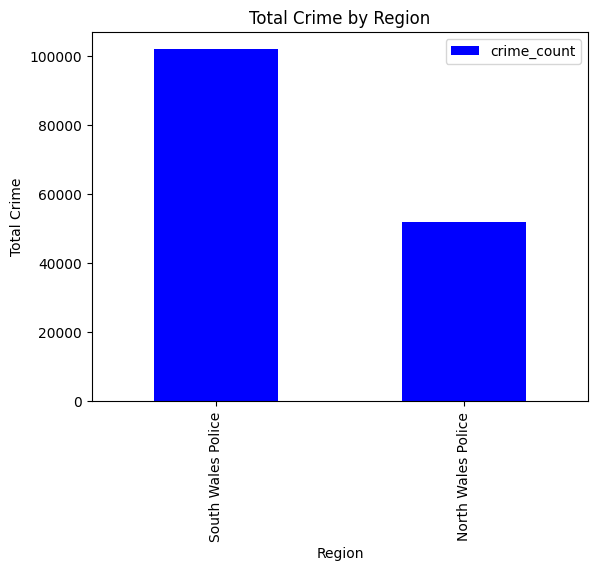

In [51]:
import matplotlib.pyplot as plt

# covert to Pandas from your PySpark DataFrame
Crime_Region = Wales_CrimebyRegion.toPandas()

# Create a bar chart of total crime by type
axis = Crime_Region.plot(kind='bar', x='Falls_within', y='crime_count', color='blue')

# Set the chart title and axis labels
axis.set_title('Total Crime by Region')
axis.set_xlabel('Region')
axis.set_ylabel('Total Crime')

# Show the chart
plt.show()

In [52]:
import pyspark.sql.functions as F
# Group crimes by falls within
Wales_CrimebyRegion= (CrimeinWales.groupBy("Falls_within")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))
Wales_CrimebyRegion.show()


+------------------+-----------+
|      Falls_within|crime_count|
+------------------+-----------+
|South Wales Police|     101787|
|North Wales Police|      51917|
+------------------+-----------+



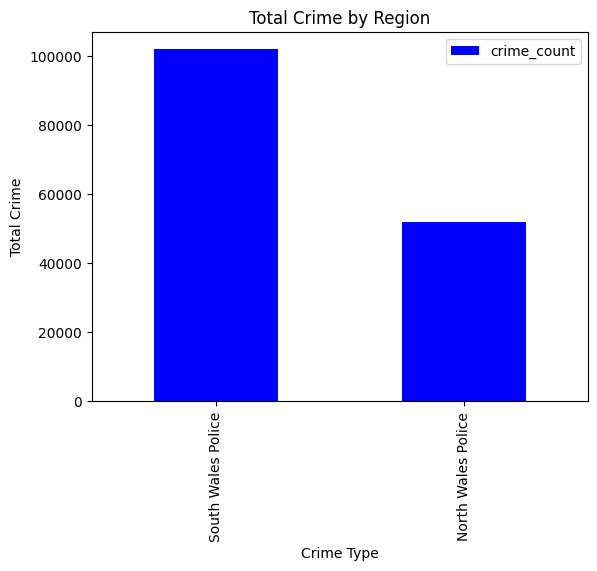

In [53]:
import matplotlib.pyplot as plt

# covert to Pandas from your PySpark DataFrame
Crime_Region = Wales_CrimebyRegion.toPandas()

# Create a bar chart of total crime by type
axis = Crime_Region.plot(kind='bar', x='Falls_within', y='crime_count', color='blue')

# Set the chart title and axis labels
axis.set_title('Total Crime by Region')
axis.set_xlabel('Crime Type')
axis.set_ylabel('Total Crime')

# Show the chart
plt.show()

In [54]:
import pyspark.sql.functions as F
# Group crimes by LSOA name
Wales_CrimebyCity= (CrimeinWales.groupBy("LSOA_name")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))
Wales_CrimebyCity.show()


+--------------------+-----------+
|           LSOA_name|crime_count|
+--------------------+-----------+
|                null|       2591|
|        Cardiff 032F|       1896|
|        Swansea 025F|       1588|
|        Cardiff 032G|       1571|
|   Denbighshire 004E|       1274|
|        Wrexham 008C|        788|
| Merthyr Tydfil 004D|        740|
|          Conwy 007C|        697|
|        Swansea 025B|        681|
|     Flintshire 003E|        671|
|        Gwynedd 001A|        628|
|        Cardiff 036B|        628|
|        Wrexham 012G|        625|
|        Cardiff 049F|        597|
|Neath Port Talbot...|        592|
|        Wrexham 011B|        560|
|The Vale of Glamo...|        522|
|   Denbighshire 006A|        511|
|        Cardiff 029D|        502|
|       Bridgend 014A|        501|
+--------------------+-----------+
only showing top 20 rows



In [55]:
from pyspark.sql.functions import substring_index

# Splitting the LSOA_name column and keeping only the city name
Wales_Crime_city = Wales_CrimebyCity.withColumn('City', substring_index('LSOA_name', ' ', 1))

# Grouping by the city name and summing the crime_count
Wales_Crime_city= Wales_Crime_city.groupBy('City').sum('crime_count').orderBy('sum(crime_count)', ascending=False)

# Renaming the sum(crime_count) column to crime_count
Wales_Crime_city = Wales_Crime_city.withColumnRenamed('sum(crime_count)', 'crime_count')

# Display top 10 cities by crime count
Wales_Crime_city.show(truncate=False, n=10)

+------------+-----------+
|City        |crime_count|
+------------+-----------+
|Cardiff     |33927      |
|Swansea     |17708      |
|Rhondda     |16589      |
|Wrexham     |11906      |
|Flintshire  |10331      |
|Conwy       |9352       |
|Neath       |8823       |
|Bridgend    |8731       |
|Denbighshire|8595       |
|The         |7975       |
+------------+-----------+
only showing top 10 rows



In [56]:
Wales_Crime_city

DataFrame[City: string, crime_count: bigint]

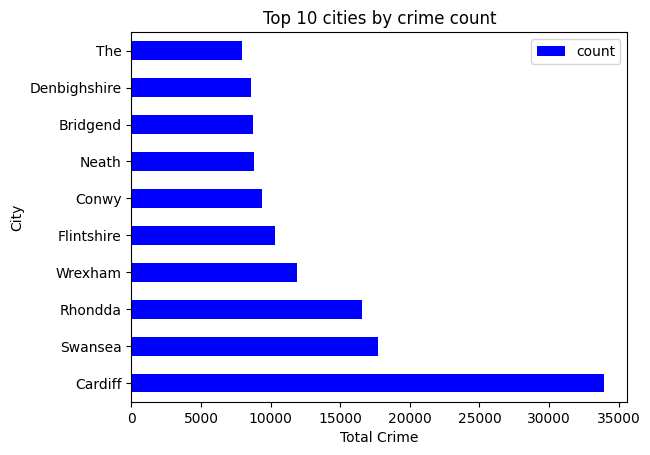

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import sum, col

# Aggregation of the count of crimes by city
Walescrimecity_data = (Wales_Crime_city
             .groupBy("City")
             .agg(sum("crime_count").alias("count"))
             .filter(col("City") != "none"))

# Converting to a Pandas DataFrame
Walescrimecity_pandas =Walescrimecity_data.toPandas()

# Sort the data in descending order by count and keep the top 10 cities
Walescrimecity_pandas = Walescrimecity_pandas .sort_values(by="count", ascending=False).head(10)

# Sort the data in descending order by count city

# Plot the data
Walescrimecity_pandas.plot(kind='barh', x='City', y='count', color='blue')

# Set the chart title and axis labels
plt.title('Top 10 cities by crime count')
plt.xlabel('Total Crime')
plt.ylabel('City')

# Show the chart
plt.show()

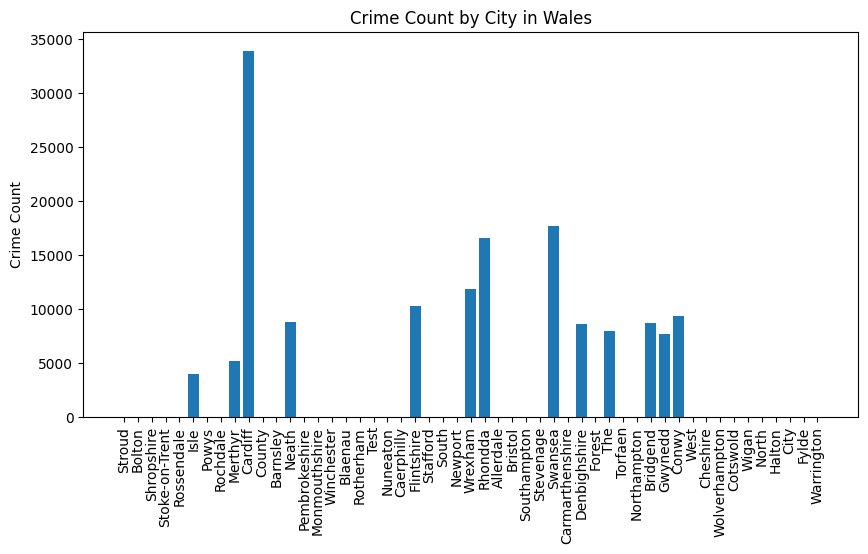

In [58]:
import matplotlib.pyplot as plt
import folium
from geopy.exc import GeocoderTimedOut

#defining the lat and long 
def get_location(city):
    try:
        return locator.geocode(city + ', Wales', timeout=10)[1]
    except GeocoderTimedOut:
        return get_location(city)

# creating a bar chart
Walescrimecity_counts = Walescrimecity_data.toPandas()
plt.figure(figsize=(10,5))
plt.bar(Walescrimecity_counts['City'], Walescrimecity_counts['count'])
plt.xticks(rotation=90)
plt.ylabel('Crime Count')
plt.title('Crime Count by City in Wales')
plt.show()

# Create a map of crime count by city
wales_map = folium.Map(location=[52.1307, 3.7837], zoom_start=8)
for row in Walescrimecity_counts.iterrows():
    city = row[1]['City']
    count = row[1]['count']
    try:
        lat, lon = get_location(city)
        marker = folium.Marker([lat, lon], popup=str(count) + ' crimes in ' + city)
        marker.add_to(wales_map)
    except:
        pass

wales_map

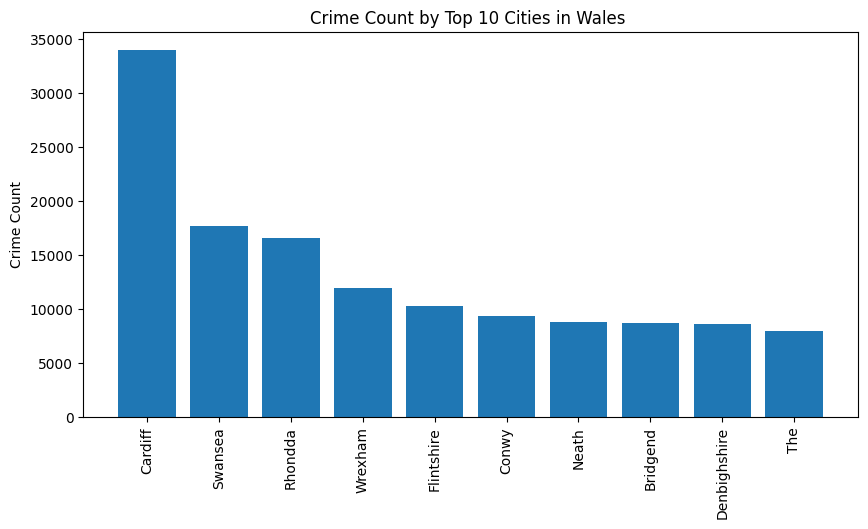

In [59]:
import matplotlib.pyplot as plt
import folium
from geopy.exc import GeocoderTimedOut

# defining the latitude and longitude
def get_location(city):
    try:
        return locator.geocode(city + ', Wales', timeout=10)[1]
    except GeocoderTimedOut:
        return get_location(city)

# creating a bar chart for the top 10 cities
Walescrimecity_counts = Walescrimecity_data.toPandas().sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.bar(Walescrimecity_counts['City'], Walescrimecity_counts['count'])
plt.xticks(rotation=90)
plt.ylabel('Crime Count')
plt.title('Crime Count by Top 10 Cities in Wales ')
plt.show()

# create a map of crime count by city for the top 10 cities
wales_map = folium.Map(location=[52.1307, 3.7837], zoom_start=8)
for row in Walescrimecity_counts.iterrows():
    city = row[1]['City']
    count = row[1]['count']
    try:
        lat, lon = get_location(city)
        marker = folium.Marker([lat, lon], popup=str(count) + ' crimes in ' + city)
        marker.add_to(wales_map)
    except:
        pass

wales_map

In [60]:
Walescrimecity_counts =Walescrimecity_data.toPandas()
print(Walescrimecity_counts.columns)

Index(['City', 'count'], dtype='object')


In [61]:
# Filter rows where Fall_within column is equal to "South Wales Police"
South_wales_Data = sqlContext.sql("select Month, Falls_within, Longitude, Latitude, Location, LSOA_name, Crime_type \
                             from CrimeinWales_Table \
                             where Falls_within = 'South Wales Police'")

South_wales_Data.show()

+-------+------------------+---------+---------+--------------------+------------------+--------------------+
|  Month|      Falls_within|Longitude| Latitude|            Location|         LSOA_name|          Crime_type|
+-------+------------------+---------+---------+--------------------+------------------+--------------------+
|2021-03|South Wales Police|-1.465837| 53.55122|On or near Beevor...|     Barnsley 015D|Violence and sexu...|
|2021-03|South Wales Police|-3.263216|51.785239|On or near Lakesi...|Blaenau Gwent 003C|Violence and sexu...|
|2021-03|South Wales Police|-3.209428| 51.78246|On or near Parkin...|Blaenau Gwent 004C|Violence and sexu...|
|2021-03|South Wales Police|-3.158945| 51.75791|On or near Aberti...|Blaenau Gwent 005C|Violence and sexu...|
|2021-03|South Wales Police|-3.243991|51.770429|On or near Morgan...|Blaenau Gwent 006E|Violence and sexu...|
|2021-03|South Wales Police|-3.660486|51.639753|On or near Griffi...|     Bridgend 001A|Anti-social behav...|
|2021-03|S

In [62]:
# Filter rows where Fall_within column is equal to "North Wales Police"
North_wales_Data = sqlContext.sql("select Month, Falls_within, Longitude, Latitude, Location, LSOA_name, Crime_type \
                             from CrimeinWales_Table \
                             where Falls_within = 'North Wales Police'")

North_wales_Data.show()

+-------+------------------+---------+---------+--------------------+--------------------+--------------------+
|  Month|      Falls_within|Longitude| Latitude|            Location|           LSOA_name|          Crime_type|
+-------+------------------+---------+---------+--------------------+--------------------+--------------------+
|2022-03|North Wales Police|-2.920133|53.179398|On or near High S...|Cheshire West and...|Criminal damage a...|
|2022-03|North Wales Police|-2.920133|53.179398|On or near High S...|Cheshire West and...|Violence and sexu...|
|2022-03|North Wales Police|-3.808299|53.320328|On or near Carmen...|          Conwy 001A|Anti-social behav...|
|2022-03|North Wales Police| -3.80707|53.321443|On or near Victor...|          Conwy 001A|Anti-social behav...|
|2022-03|North Wales Police|-3.812011|53.320074|On or near Curzon...|          Conwy 001A|Anti-social behav...|
|2022-03|North Wales Police|-3.811959|53.321675|On or near Back E...|          Conwy 001A|Anti-social be

In [63]:
from pyspark.sql.functions import count

# Group by Crime_type and count the crimes
south_wales_region_count = (South_wales_Data
                            .groupBy("Crime_type")
                            .agg(count("*").alias("crime_count"))
                            .orderBy("crime_count", ascending=False))

south_wales_region_count.show()

+--------------------+-----------+
|          Crime_type|crime_count|
+--------------------+-----------+
|Violence and sexu...|      31072|
|Anti-social behav...|      27174|
|        Public order|       9356|
|Criminal damage a...|       8267|
|         Shoplifting|       5885|
|         Other theft|       5347|
|       Vehicle crime|       4729|
|            Burglary|       2999|
|               Drugs|       2881|
|         Other crime|       1626|
|       Bicycle theft|       1011|
|Possession of wea...|        539|
|Theft from the pe...|        534|
|             Robbery|        367|
+--------------------+-----------+



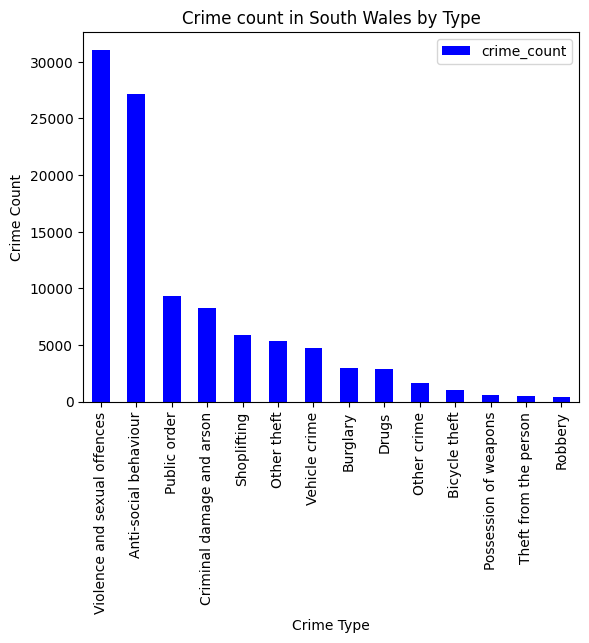

In [64]:
import matplotlib.pyplot as plt

# covert to Pandas from your PySpark DataFrame
crime_type = south_wales_region_count.toPandas()

# Create a bar chart of total crime by type
axis = crime_type.plot(kind='bar', x='Crime_type', y='crime_count', color='blue')

# Set the chart title and axis labels
axis.set_title('Crime count in South Wales by Type')
axis.set_xlabel('Crime Type')
axis.set_ylabel('Crime Count')

# Show the chart
plt.show()

In [69]:
NorthWales_category = (North_wales_region_count.select('*')
        .groupBy('Crime_type')
        .agg(count("Crime_type").alias('Total_crime'))
        .orderBy('Crime_type')
          )

CrimeinWales2_category.show(100)

CrimeinWales2_category.agg({"Total_Crime": "Sum"}).show()

NameError: name 'North_wales_region_count' is not defined

In [ ]:
from pyspark.sql.functions import count

# Group by Crime_type and count the crimes
North_wales_region_count = (North_wales_Data
                            .groupBy("Crime_type")
                            .agg(count("*").alias("crime_count"))
                            .orderBy("crime_count", ascending=False))

North_wales_region_count.show()

In [ ]:
import matplotlib.pyplot as plt

# covert to Pandas from your PySpark DataFrame
crime_type = North_wales_region_count.toPandas()

# Create a bar chart of total crime by type
axis = crime_type.plot(kind='bar', x='Crime_type', y='crime_count', color='blue')

# Set the chart title and axis labels
axis.set_title('Crime count in North Wales by Type')
axis.set_xlabel('Crime Type')
axis.set_ylabel('Crime count')

# Show the chart
plt.show()

# Register a new table for North wales

In [68]:

North_wales_Data.registerTempTable("Northwales_Table")

# getting month count for North wales

In [ ]:
#get the counts for each month ordered in descending order
North_wales_Data.groupby("Month").count().orderBy(desc("count")).show()

# create new dataframe for month count in Northwales

In [ ]:
# Create new data frame with Month and Counts per Month
NorthWalesCrime = North_wales_Data.select(North_wales_Data.Month)\
.groupby(North_wales_Data.Month).count()
NorthWalesCrime.show()

In [ ]:
NorthWalesMonthlyCrime=NorthWalesCrime.orderBy('Month')
NorthWalesMonthlyCrime.show()

In [ ]:
#get the counts for each month ordered in descending order
South_wales_Data.groupby("Month").count().orderBy(desc("count")).show()

In [ ]:

NorthWalesMonthlyCrime.registerTempTable("Northwalesmonthly_Table")


In [ ]:
# Register the monthlyCrimeAmount 
# DataFrame as a temp table and show the contents
NorthWalesMonthlyCrime.registerTempTable("NorthWalesMonthlyCrime")
sqlContext.sql("select * from Northwalesmonthly_Table").show()


In [ ]:



y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime by month')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('month')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("Crime by month.png")
plt.show()

In [ ]:
# Create new data frame with Month and Counts per Month
NorthWalesMonthlyCrime = North_wales_Data.select(North_wales_Data.Month)\
.groupby(North_wales_Data.Month).count()
North_wales_Data.show()

In [ ]:
import pyspark.sql.functions as F
# Group crimes by LSOA_name
SouthWales_CrimebyCity= (South_wales_Data.groupBy("LSOA_name")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))
SouthWales_CrimebyCity.show()

In [ ]:
from pyspark.sql.functions import substring_index

# Splitting the LSOA_name column and keeping only the city name
SouthWales_Crime_city = SouthWales_CrimebyCity.withColumn('City', substring_index('LSOA_name', ' ', 1))

# Grouping by the city name and summing the crime_count
SouthWales_Crime_city= SouthWales_Crime_city.groupBy('City').sum('crime_count').orderBy('sum(crime_count)', ascending=False)

# Renaming the sum(crime_count) column to crime_count
SouthWales_Crime_city = SouthWales_Crime_city.withColumnRenamed('sum(crime_count)', 'crime_count')

# Display top 10 cities by crime count
Wales_Crime_city.show(truncate=False, n=10)

In [ ]:
import pyspark.sql.functions as F
# Group crimes by LSOA_name
NorthWales_CrimebyCity= (North_wales_Data.groupBy("LSOA_name")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))
NorthWales_CrimebyCity.show()

In [ ]:
from pyspark.sql.functions import substring_index

# Splitting the LSOA_name column and keeping only the city name
NorthWales_Crime_city = NorthWales_CrimebyCity.withColumn('City', substring_index('LSOA_name', ' ', 1))

# Grouping by the city name and summing the crime_count
NorthWales_Crime_city= NorthWales_Crime_city.groupBy('City').sum('crime_count').orderBy('sum(crime_count)', ascending=False)

# Renaming the sum(crime_count) column to crime_count
NorthWales_Crime_city = NorthWales_Crime_city.withColumnRenamed('sum(crime_count)', 'crime_count')

# Display top 10 cities by crime count
NorthWales_Crime_city.show(truncate=False, n=10)

In [ ]:
north_wales_fall_within_location_crime_count = (north_wales_crime_df.groupBy("Falls_within", "LSOA_name")
                                                .agg(F.count("*").alias("crime_count"))
                                                .orderBy("crime_count", ascending=False))

In [ ]:
# Create new data frame with Month and Counts per Month
CrimeinWales2 = CrimeinWales.select(CrimeinWales.Month)\
.groupby(CrimeinWales.Month).count()

In [ ]:
CrimeinWales2.orderBy(desc("Month")).show()